# Decision Tree Learning Algorithm Implementation With Entropy

In this project a decision tree for a binary classification dataset is implemented. For evaluation, 5-fold cross-validation is implemented and applied. Main purpose of the project is to see how entropy is used to determine the nodes of the decision trees.

**Important Notes:** 
- In this project entropy calculations are made based on binary classification and all data fields are assumed to be numeric. Necessary changes should be made for regression datasets, classification datasets with more than 2 classes and datasets with categorical fields.
- In this implementation overfit avoidance methods like **max depth and min size** are not used.
   

### Entropy

This function calculates the entropy of a given dataset according to the following formula: 

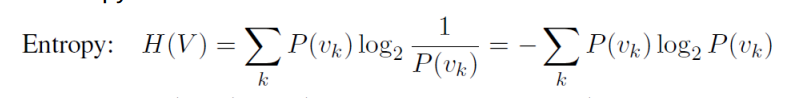

or equivalently:

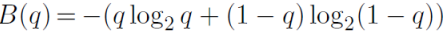

In [1]:
import math

def entropy(data):
    
    # if all of the values are of the same type then entropy is 0
    target_classes = data.iloc[:, -1].nunique()
    if target_classes < 2:
        return 0
    
    # if there are 2 different classes in the dataset, then calculate entropy
    
    # get the counts of different classes
    target_counts = data.iloc[:, -1].value_counts()
    # get the total number of data points
    total_instances = np.sum(target_counts)
    
    # apply the given formula
    entropy = -((target_counts[0]/total_instances) * math.log2((target_counts[0]/total_instances)) +  
                (target_counts[1]/total_instances) * math.log2((target_counts[1]/total_instances)))
    
    # return entropy of the given dataset
    return entropy

### Information Gain
Information gain is the answer of "How to use entropy to select attributes?". If the information gain of selection of an attribute as the node is high, then it is preferred. 

Below function calculates information gain according to the formula:



Here average stands for weighted average.

In [2]:
# takes a dataset, column name and value for split
def information_gain(data, column_name, value):
    
    total_instances = data.shape[0] # total number of data points 
    parent_entropy = entropy(data) # entropy of the given dataset
    
    # split given data from given column and value, name them as left and right children
    leftchild, rightchild = split(data, column_name, value) 
    
    # calculate weighted averages of children 
    w_average = ((leftchild.shape[0]/total_instances) * entropy(leftchild) +
                (rightchild.shape[0]/total_instances) * entropy(rightchild))
    
    # calculate information gain based on given split point
    gain = parent_entropy - w_average
    
    # return the gain and children 
    return gain, leftchild, rightchild

In [3]:
# this function splits the given dataset from the split point specified by column_name and val
def split(data, column_name, val):
    left = data[data[column_name] < val]   
    right = data[data[column_name] >= val] 
    
    # return the left and right splits
    return left, right

In [4]:
# this function takes a dataset and iterates each cell of it to find best split point
def find_best_split(data):
    best_column = "" 
    best_value = 0
    best_gain = 0
    left_split = None
    right_split = None
    
    for column_name in column_names: # iterate over columns
        for index, row in data.iterrows(): # iterate over rows
            
            # get the gain
            gain, left, right = information_gain(data, column_name, row[column_name])
            
            # update the best split information if new gain is better
            if gain > best_gain:
                best_column = column_name
                best_value = row[column_name]
                best_gain = gain
                left_split = left
                right_split = right
                
    # return the split node as dictionary
    return {'split_column': best_column, 
            'split_value': best_value, 
            'left_split': left_split, 
            'right_split': right_split}

In [5]:
# this function takes a dataset and makes it terminal by assigning most repeated class to it

# note that in our recursive_tree_build implementation we are splitting nodes until they are pure
# therefore this function becomes more usefull when mentioned methods like max_depth or min_size are applied

def make_terminal_and_set_prediction(data):
    # all classes
    classes = np.array([row[-1] for index, row in data.iterrows()]).astype(int)
    # most repeated one
    prediction = np.bincount(classes).argmax()
    # return prediction
    return prediction

In [6]:
# this function takes the root node of the tree and builds the entire tree recursively until it reaches a pure node 
def recursive_tree_build(node):
    target_classes_left = node['left_split'].iloc[:, -1].nunique() # number of unique classes in left split
    target_classes_right = node['right_split'].iloc[:, -1].nunique() # number of unique classes in left split
    left_split = node['left_split']
    right_split = node['right_split']
    
    # check if one of the splits is empty, if so merge them and make them terminal node
    if left_split.shape[0] == 0 or right_split.shape[0] == 0:
        node['left'] = node['right'] = make_terminal_and_set_prediction(pd.concat([left_split, right_split], axis=0, ignore_index=True))
        return
    
    # if left split is pure, make it terminal
    if target_classes_left == 1:
        node['left'] = make_terminal_and_set_prediction(node['left_split'])
        
    # else split it and make recursive call
    else:
        node['left'] = find_best_split(left_split)
        recursive_tree_build(node['left'])
    
    # if right split is pure, make it terminal
    if target_classes_right == 1:
        node['right'] = make_terminal_and_set_prediction(node['right_split'])
        
    # else split it and make recursive call
    else:
        node['right'] = find_best_split(right_split)
        recursive_tree_build(node['right'])
    

In [7]:
# this function is to initialize the recursive build
def make_decision_tree(train_data):
    # find the root 
    root = find_best_split(train_data)
    # call recursion function
    recursive_tree_build(root)
    # return root node
    return root

In [8]:
# this function takes a data point and search the given decision tree recursively to find its predicted value
def make_prediction(node, data_point):
    
    # search left
    if node['split_value'] > data_point[node['split_column']]:
        
        # not terminal
        if isinstance(node['left'], dict):
            
            # make recursive call
            return make_prediction(node['left'], data_point)
        
        # terminal
        else:
            
            # return prediction
            return node['left']
        
    # search right
    else:
        
        # not terminal
        if isinstance(node['right'], dict):
            
            # make recursive call
            return make_prediction(node['right'], data_point)
        
        # terminal
        else:
            
            # return prediction
            return node['right']

### Dataset
I have used a dataset about Rice Classification. You can also find it from [UCI ML Repository](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik).

I will provide the dataset information from the website:
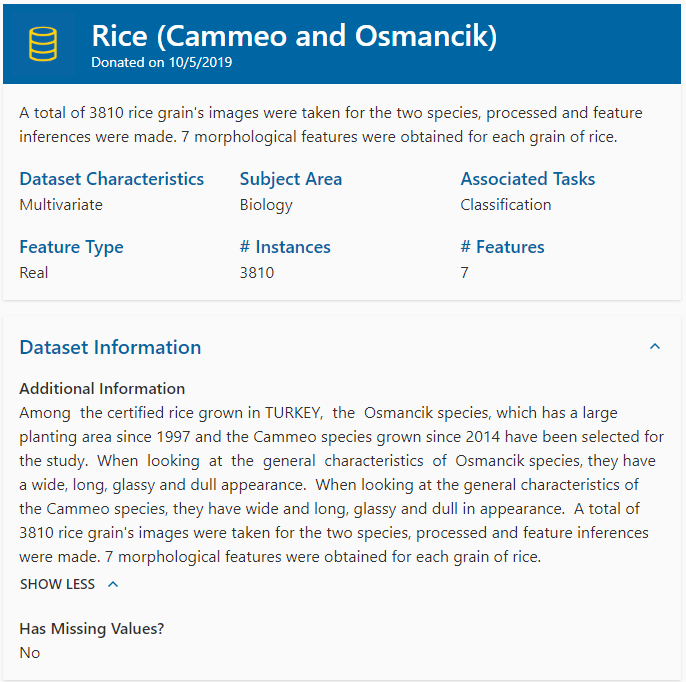

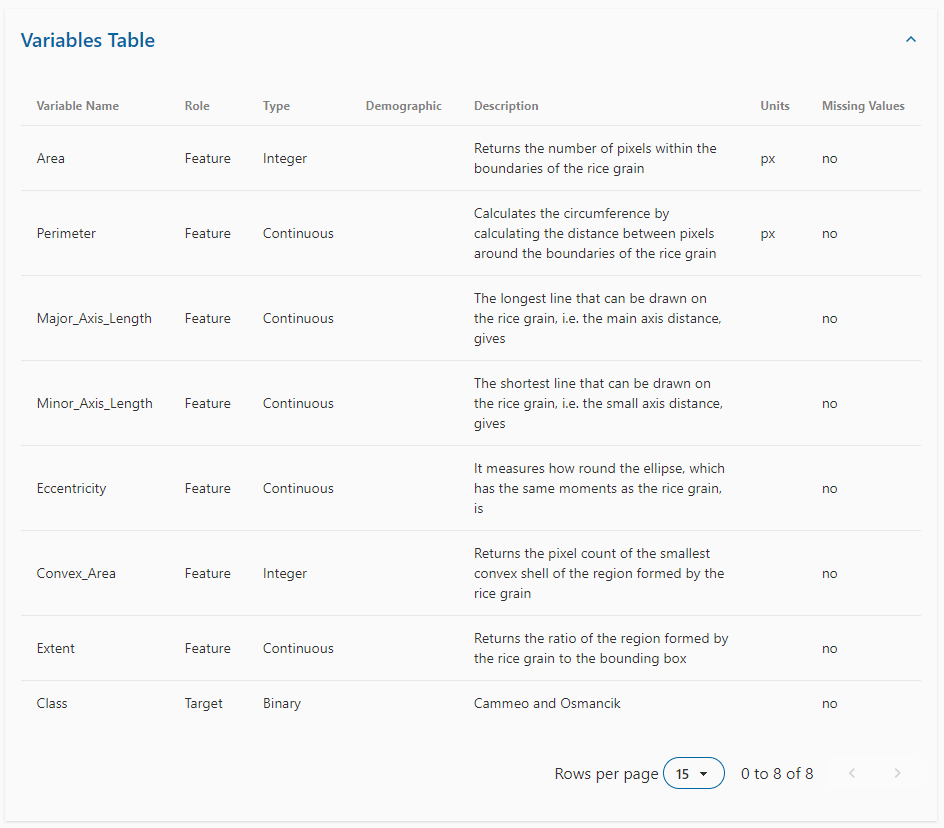

In [9]:
# import ucimlrepo for dataset
from ucimlrepo import fetch_ucirepo 

#import necessary libraries
import pandas as pd
import numpy as np

# arrange the display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# fetch dataset 
rice_cammeo_and_osmancik = fetch_ucirepo(id=545) 
  
# data (as pandas dataframes) 
X = rice_cammeo_and_osmancik.data.features 
y = rice_cammeo_and_osmancik.data.targets 

# column names will be used for tree splits
column_names = X.columns
print("Column Names:", column_names) 
print("##################################################")


# variable information (same as provided earlier from site)
print(rice_cammeo_and_osmancik.variables) 
print("##################################################")


# let's put test set aside for now
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=480)

# lets merge x and y to keep all data together
dataset = pd.concat([X_train, y_train], axis=1) 
test_set = pd.concat([X_test, y_test], axis=1)

# Lets replace Cammeo with 1 and Osmancik with 0 at target
dataset['Class'] = (dataset['Class'] == "Cammeo").astype(int)
test_set['Class'] = (test_set['Class'] == "Cammeo").astype(int)

# take a look at the table
print(dataset.head())


Column Names: Index(['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent'], dtype='object')
##################################################
                name     role        type demographic                                        description units missing_values
0               Area  Feature     Integer        None  Returns the number of pixels within the bounda...    px             no
1          Perimeter  Feature  Continuous        None  Calculates the circumference by calculating th...    px             no
2  Major_Axis_Length  Feature  Continuous        None  The longest line that can be drawn on the rice...  None             no
3  Minor_Axis_Length  Feature  Continuous        None  The shortest line that can be drawn on the ric...  None             no
4       Eccentricity  Feature  Continuous        None  It measures how round the ellipse, which has t...  None             no
5        Convex_Area  Feature     Integer        No

### k-fold Cross-Validation

I will apply k-fold cross validation on train set only. Another approach could be applying it to whole dataset and recording the results but I want to test my models on an unseen data also, which will be done in the next section. 

- The use of k-fold cross-validation ensures that our model does not overfit to one train dataset, or at least give us the chance to realize if it does. Using only train-test split and getting 93% accuracy does not give enough confidence compared to getting accuracies 91.7, 95, 92, 94, 90 using 5-fold cross-validation. Using k-fold and getting these results proves that our model is generalizing the patterns in the model and actively learning, consequently giving reliable results.

- Another benefit of the k-fold cross validation is the efficient use of the dataset. We are using every instance of the train dataset to validate our model. This gives us the ability for better performance evaluation. The reason is as follows: The performance of a model evaluated with simple train-test split heavily depends on which data points were in the test and train datasets. k-fold cross validation overcomes this issue by spliting the data k times.

###########################################

Confusion Matrix of fold 1 :


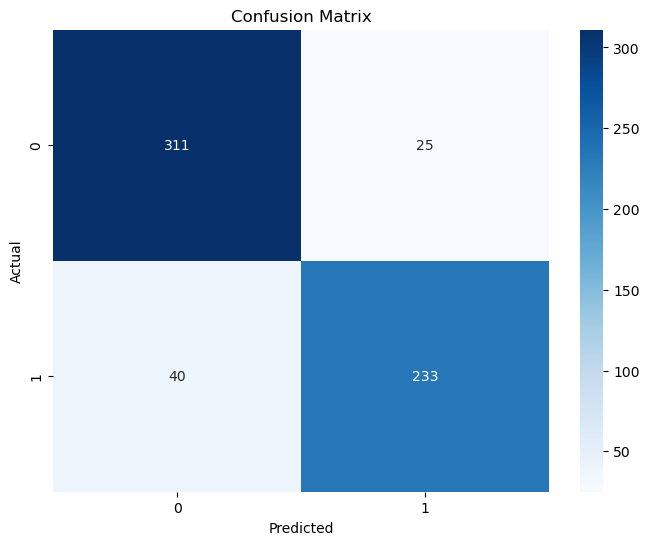

Accuracy of fold 1 : 89.33%
Precision of fold 1 : 90.31%
Recall of fold 1 : 85.35%
F1 Score of fold 1 : 87.76%
###########################################

Confusion Matrix of fold 2 :


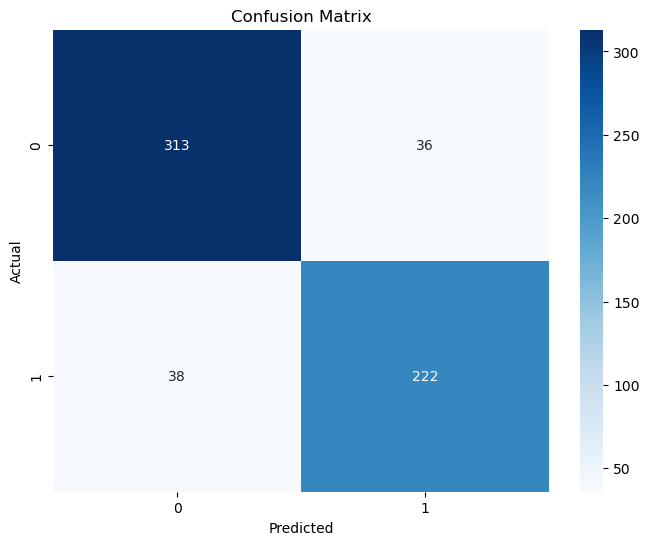

Accuracy of fold 2 : 87.85%
Precision of fold 2 : 86.05%
Recall of fold 2 : 85.38%
F1 Score of fold 2 : 85.71%
###########################################

Confusion Matrix of fold 3 :


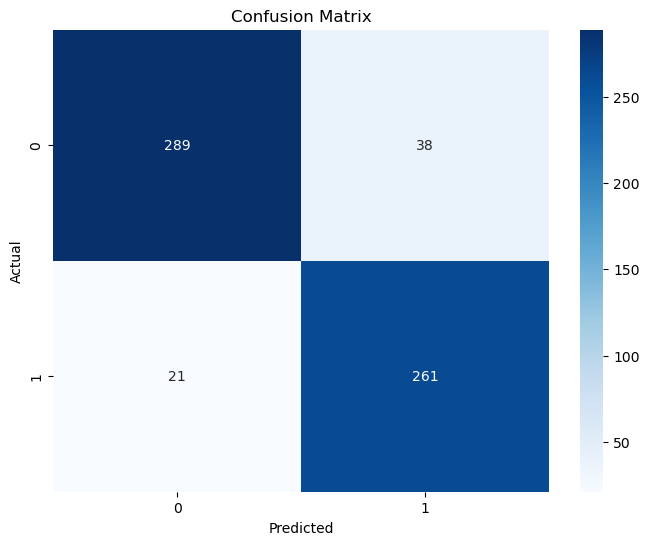

Accuracy of fold 3 : 90.31%
Precision of fold 3 : 87.29%
Recall of fold 3 : 92.55%
F1 Score of fold 3 : 89.85%
###########################################

Confusion Matrix of fold 4 :


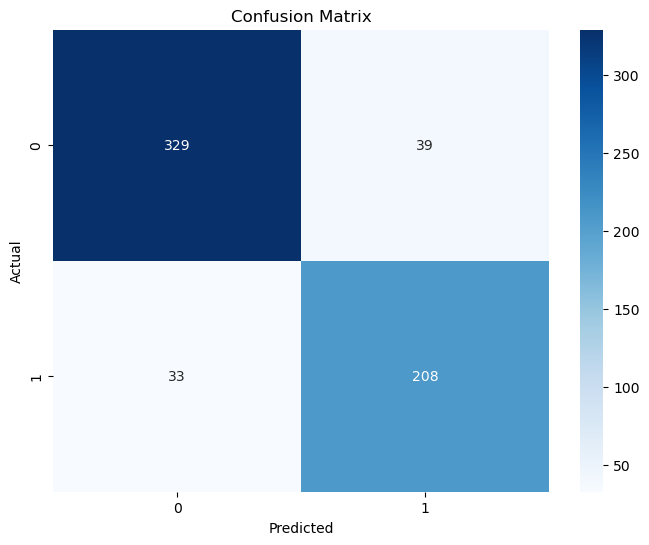

Accuracy of fold 4 : 88.18%
Precision of fold 4 : 84.21%
Recall of fold 4 : 86.31%
F1 Score of fold 4 : 85.25%
###########################################

Confusion Matrix of fold 5 :


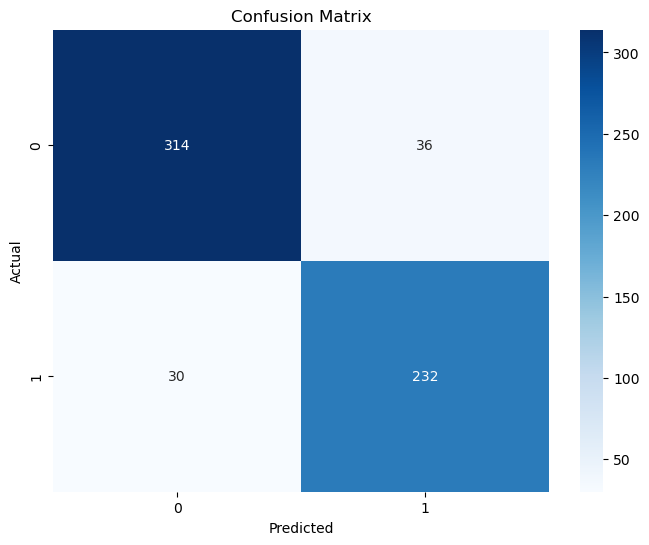

Accuracy of fold 5 : 89.22%
Precision of fold 5 : 86.57%
Recall of fold 5 : 88.55%
F1 Score of fold 5 : 87.55%


In [10]:
# import libraries for visulisation
import matplotlib.pyplot as plt
import seaborn as sns

# lets apply 5-fold cross validation on train set
num_folds = 5

# shuffle the train set
dataset = dataset.sample(frac=1, random_state=480).reset_index(drop=True)

# size of each fold
fold_size = len(dataset) // num_folds

# lets also store metrics for each tree
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []

# store each tree
trees = []

# Apply 5-fold cross-validation and plot errors for each
for i in range(num_folds):
    # Define the indices for the current fold
    start_idx = i * fold_size
    end_idx = 0
    if i < num_folds - 1:
        end_idx = (i + 1) * fold_size
    else: 
        end_idx = len(dataset)

    # Validation set for the current fold
    validation_set = dataset.iloc[start_idx:end_idx]

    # Training set for the current fold
    train_set = pd.concat([dataset.iloc[:start_idx], dataset.iloc[end_idx:]], axis=0, ignore_index=True)
    
    # store real values for error calculation
    fold_actual_classes = validation_set['Class'].values
    
    # train the model
    tree = make_decision_tree(train_set)
    trees.append(tree)
    
    # make predictions and store them in an array
    fold_predicts = []
    for index, row in validation_set.iterrows():
        fold_prediction = make_prediction(tree, row)
        fold_predicts.append(fold_prediction)
    
    # lets use numpy array for easy calculations
    fold_predictions = np.array(fold_predicts)
    
    # accuracy calculation
    fold_accuracy = np.mean(fold_predictions == fold_actual_classes)
    fold_accuracies.append(fold_accuracy)
    
    # confusion matrix and visualisation with heatmap
    fold_confusion_matrix = pd.crosstab(fold_actual_classes, fold_predictions, rownames=['Actual'], colnames=['Predicted'])
    print("###########################################")
    print(f'\nConfusion Matrix of fold {i + 1} :')
    plt.figure(figsize=(8, 6))
    sns.heatmap(fold_confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # calculate other metrices and print them
    fold_precision = np.sum((fold_predictions == 1) & (fold_actual_classes == 1)) / np.sum(fold_predictions == 1)
    fold_recall = np.sum((fold_predictions == 1) & (fold_actual_classes == 1)) / np.sum(fold_actual_classes == 1)
    fold_f1_score = 2 * (fold_precision * fold_recall) / (fold_precision + fold_recall)
    fold_precisions.append(fold_precision)
    fold_recalls.append(fold_recall)
    fold_f1_scores.append(fold_f1_score)
    print(f'Accuracy of fold {i + 1} : {fold_accuracy:.2%}')
    print(f'Precision of fold {i + 1} : {fold_precision:.2%}')
    print(f'Recall of fold {i + 1} : {fold_recall:.2%}')
    print(f'F1 Score of fold {i + 1} : {fold_f1_score:.2%}')
    
    

As we can see the results of the 5-folds are close to each other, therefore we can say that our model generalizes the data instead of overfitting. Let's also see the average results:

[0.8932676518883416, 0.8784893267651889, 0.90311986863711, 0.8817733990147784, 0.8921568627450981]
Mean Accuracy: 88.98% ± 0.88%
Mean Precision: 86.89% ± 1.99%
Mean Recall: 87.63% ± 2.72%
Mean F1 Score: 87.22% ± 1.64%


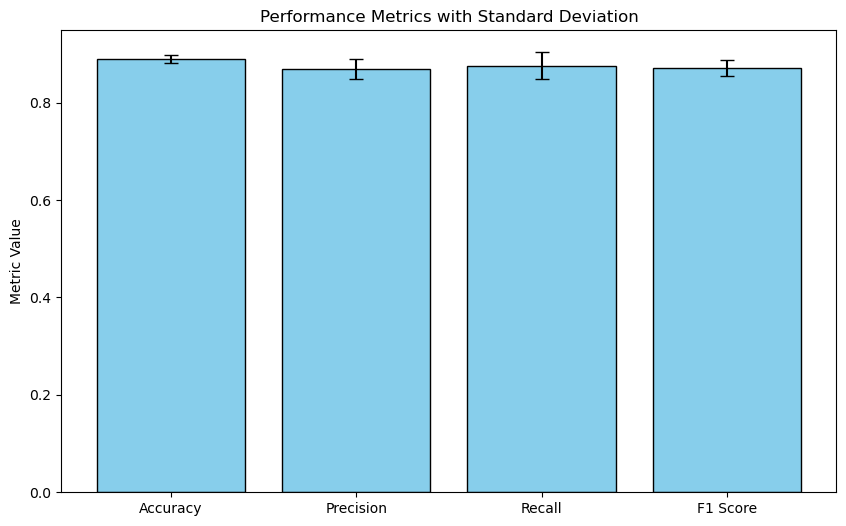

In [11]:
mean_fold_accuracy = np.mean(fold_accuracies)
std_fold_accuracy = np.std(fold_accuracies)

mean_fold_precision = np.mean(fold_precisions)
std_fold_precision = np.std(fold_precisions)

mean_fold_recall = np.mean(fold_recalls)
std_fold_recall = np.std(fold_recalls)

mean_fold_f1_score = np.mean(fold_f1_scores)
std_fold_f1_score = np.std(fold_f1_scores)

# Print the results
print(fold_accuracies)
print(f'Mean Accuracy: {mean_fold_accuracy:.2%} ± {std_fold_accuracy:.2%}')
print(f'Mean Precision: {mean_fold_precision:.2%} ± {std_fold_precision:.2%}')
print(f'Mean Recall: {mean_fold_recall:.2%} ± {std_fold_recall:.2%}')
print(f'Mean F1 Score: {mean_fold_f1_score:.2%} ± {std_fold_f1_score:.2%}')

# Metrics and their corresponding means and standard deviations
fold_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fold_means = [mean_fold_accuracy, mean_fold_precision, mean_fold_recall, mean_fold_f1_score]
fold_stds = [std_fold_accuracy, std_fold_precision, std_fold_recall, std_fold_f1_score]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot of means with error bars
ax.bar(fold_metrics, fold_means, yerr=fold_stds, capsize=5, color='skyblue', edgecolor='black')

# Set labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Performance Metrics with Standard Deviation')

# Show the plot
plt.show()

###########################################

Confusion Matrix of tree 1 on TEST_SET:


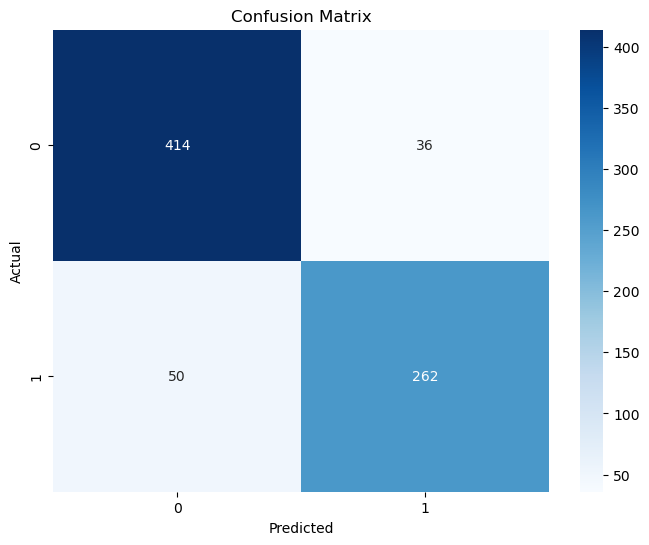

Accuracy of tree 1 on TEST_SET : 88.71%
Precision of tree 1 on TEST_SET : 87.92%
Recall of tree 1 on TEST_SET : 83.97%
F1 Scoreof tree 1 on TEST_SET : 85.90%
###########################################

Confusion Matrix of tree 2 on TEST_SET:


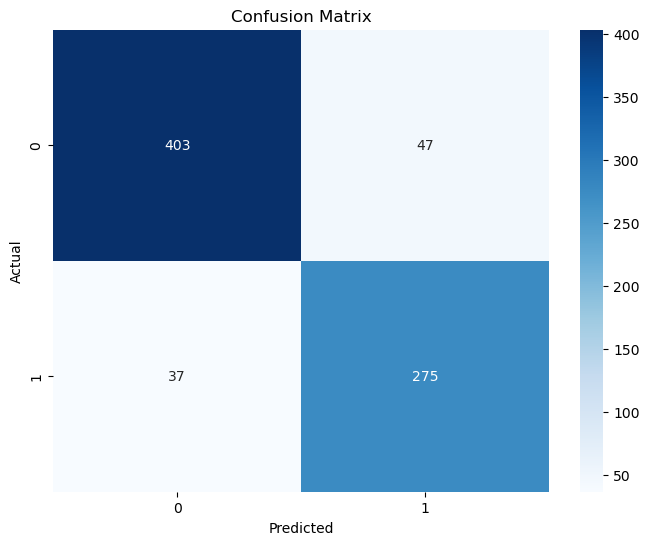

Accuracy of tree 2 on TEST_SET : 88.98%
Precision of tree 2 on TEST_SET : 85.40%
Recall of tree 2 on TEST_SET : 88.14%
F1 Scoreof tree 2 on TEST_SET : 86.75%
###########################################

Confusion Matrix of tree 3 on TEST_SET:


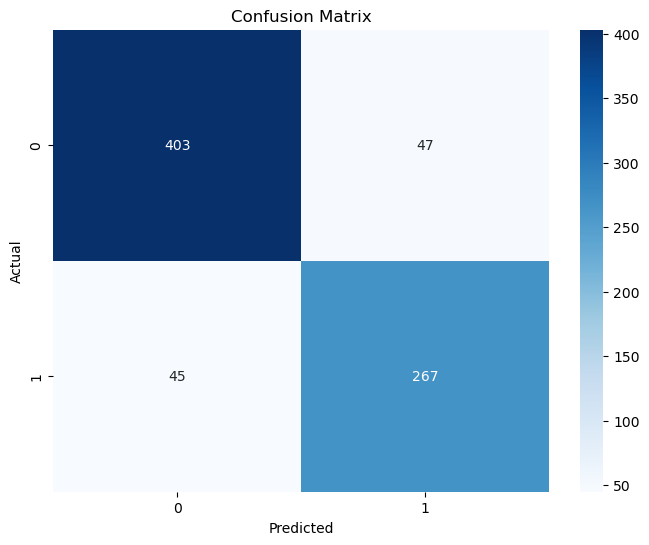

Accuracy of tree 3 on TEST_SET : 87.93%
Precision of tree 3 on TEST_SET : 85.03%
Recall of tree 3 on TEST_SET : 85.58%
F1 Scoreof tree 3 on TEST_SET : 85.30%
###########################################

Confusion Matrix of tree 4 on TEST_SET:


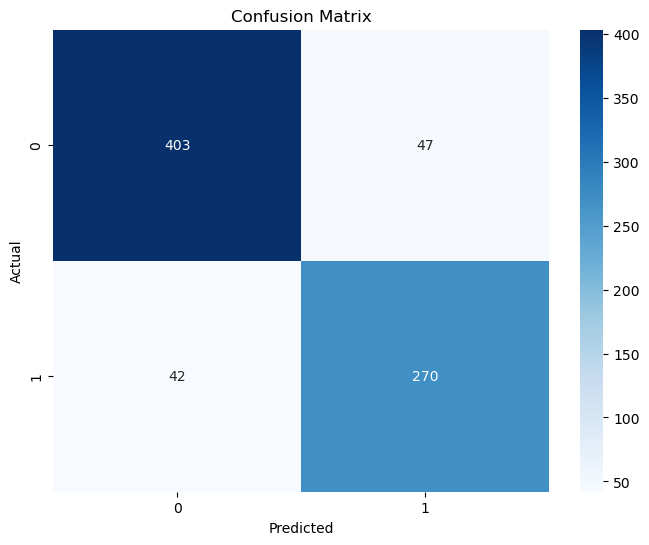

Accuracy of tree 4 on TEST_SET : 88.32%
Precision of tree 4 on TEST_SET : 85.17%
Recall of tree 4 on TEST_SET : 86.54%
F1 Scoreof tree 4 on TEST_SET : 85.85%
###########################################

Confusion Matrix of tree 5 on TEST_SET:


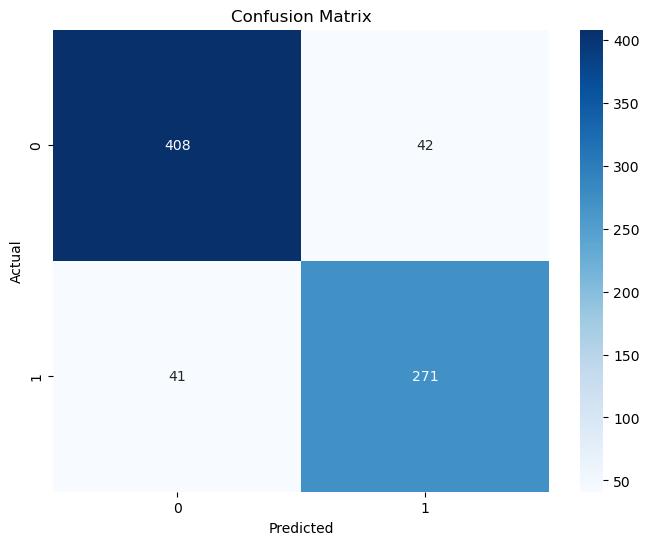

Accuracy of tree 5 on TEST_SET : 89.11%
Precision of tree 5 on TEST_SET : 86.58%
Recall of tree 5 on TEST_SET : 86.86%
F1 Scoreof tree 5 on TEST_SET : 86.72%


In [12]:
# NOW WE HAVE 5 DECISION TREES, WE CAN TRY EACH OF THEM ON OUR TEST DATASET TO SELECT THE BEST

# REMEMBER NONE OF THE TREES HAVE SEEN THE TEST DATA BEFORE

# lets also store metrics for each tree
test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []

i = 0 # indicates tree number
# iterate through each tree
for tree in trees:
    
    # store real values for error calculation
    test_actual_classes = test_set['Class'].values
    
    # make predictions and store them in an array
    test_predicts = []
    for index, row in test_set.iterrows():
        test_prediction = make_prediction(tree, row)
        test_predicts.append(test_prediction)
    test_predictions = np.array(test_predicts)
    
    # accuracy calculation
    test_accuracy = np.mean(test_predictions == test_actual_classes)
    test_accuracies.append(test_accuracy)
    
    # confusion matrix and visualisation with heatmap
    test_confusion_matrix = pd.crosstab(test_actual_classes, test_predictions, rownames=['Actual'], colnames=['Predicted'])
    print("###########################################")
    print(f'\nConfusion Matrix of tree {i+1} on TEST_SET:')
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # calculate other metrices and print them
    test_precision = np.sum((test_predictions == 1) & (test_actual_classes == 1)) / np.sum(test_predictions == 1)
    test_recall = np.sum((test_predictions == 1) & (test_actual_classes == 1)) / np.sum(test_actual_classes == 1)
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1_score)
    print(f'Accuracy of tree {i+1} on TEST_SET : {test_accuracy:.2%}')
    print(f'Precision of tree {i+1} on TEST_SET : {test_precision:.2%}')
    print(f'Recall of tree {i+1} on TEST_SET : {test_recall:.2%}')
    print(f'F1 Scoreof tree {i+1} on TEST_SET : {test_f1_score:.2%}')
    i += 1
    
    

Mean Accuracy: 88.61% ± 0.43%
Mean Precision: 86.02% ± 1.10%
Mean Recall: 86.22% ± 1.39%
Mean F1 Score: 86.11% ± 0.56%


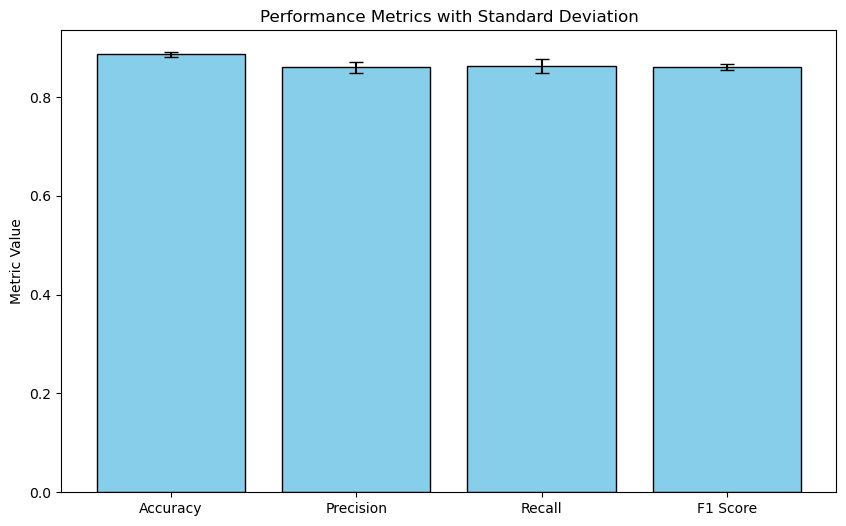

In [13]:
# Let's also see the average results for test dataset
mean_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

mean_test_precision = np.mean(test_precisions)
std_test_precision = np.std(test_precisions)

mean_test_recall = np.mean(test_recalls)
std_test_recall = np.std(test_recalls)

mean_test_f1_score = np.mean(test_f1_scores)
std_test_f1_score = np.std(test_f1_scores)

# Print the results
print(f'Mean Accuracy: {mean_test_accuracy:.2%} ± {std_test_accuracy:.2%}')
print(f'Mean Precision: {mean_test_precision:.2%} ± {std_test_precision:.2%}')
print(f'Mean Recall: {mean_test_recall:.2%} ± {std_test_recall:.2%}')
print(f'Mean F1 Score: {mean_test_f1_score:.2%} ± {std_test_f1_score:.2%}')

# Metrics and their corresponding means and standard deviations
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
test_means = [mean_test_accuracy, mean_test_precision, mean_test_recall, mean_test_f1_score]
test_stds = [std_test_accuracy, std_test_precision, std_test_recall, std_test_f1_score]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot of means with error bars
ax.bar(test_metrics, test_means, yerr=test_stds, capsize=5, color='skyblue', edgecolor='black')

# Set labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Performance Metrics with Standard Deviation')

# Show the plot
plt.show()

### Selecting Final/Best tree

To select the best tree among 5, I will consider the overall correctness(accuracy) tohether with minimizing false positives(high precision) and false negatives(high recall) on test data. 

For this purpose, it is appropriate to check for high accuracy together with high F1 score. Our decision evaluates to **Tree 5**.

Let's visualise the tree:

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_custom_tree(node, depth=0, pos=(0, 0), parent=None, branch_type=None):
    if isinstance(node, dict):
        current_pos = (pos[0], pos[1])
        plt.text(current_pos[0], current_pos[1], f'{node["split_column"]} < {node["split_value"]:.3f}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

        if parent is not None:
            plt.plot([parent[0], current_pos[0]], [parent[1], current_pos[1]], linestyle='-', color='black' if branch_type is None else 'green' if branch_type == 'left' else 'red')

        left_pos = (pos[0] - 2 ** (max_depth - depth - 1), pos[1] - 1)
        right_pos = (pos[0] + 2 ** (max_depth - depth - 1), pos[1] - 1)

        plot_custom_tree(node['left'], depth + 1, left_pos, current_pos, 'left')
        plot_custom_tree(node['right'], depth + 1, right_pos, current_pos, 'right')
    else:
        plt.text(pos[0], pos[1], f'Predict: {node}', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

# Assuming your tree structure is stored in the variable `tree`
max_depth = 30  # Set this to an appropriate value based on your tree depth
plt.figure(figsize=(80, 60))  # Increase the figure size
plot_custom_tree(trees[4])

# Save the plot to an external file (e.g., PNG)
plt.savefig('decision_tree_plot.png')

# Optionally, close the plot if you don't want to display it in the notebook
plt.close()

This is just a small portion of the tree. It is hard to draw such a big tree in visible way but original tree is [here](https://drive.google.com/file/d/10vt8ctGD3Jra-rH_gvdjbkPZsEbfYOj9/view?usp=sharing).

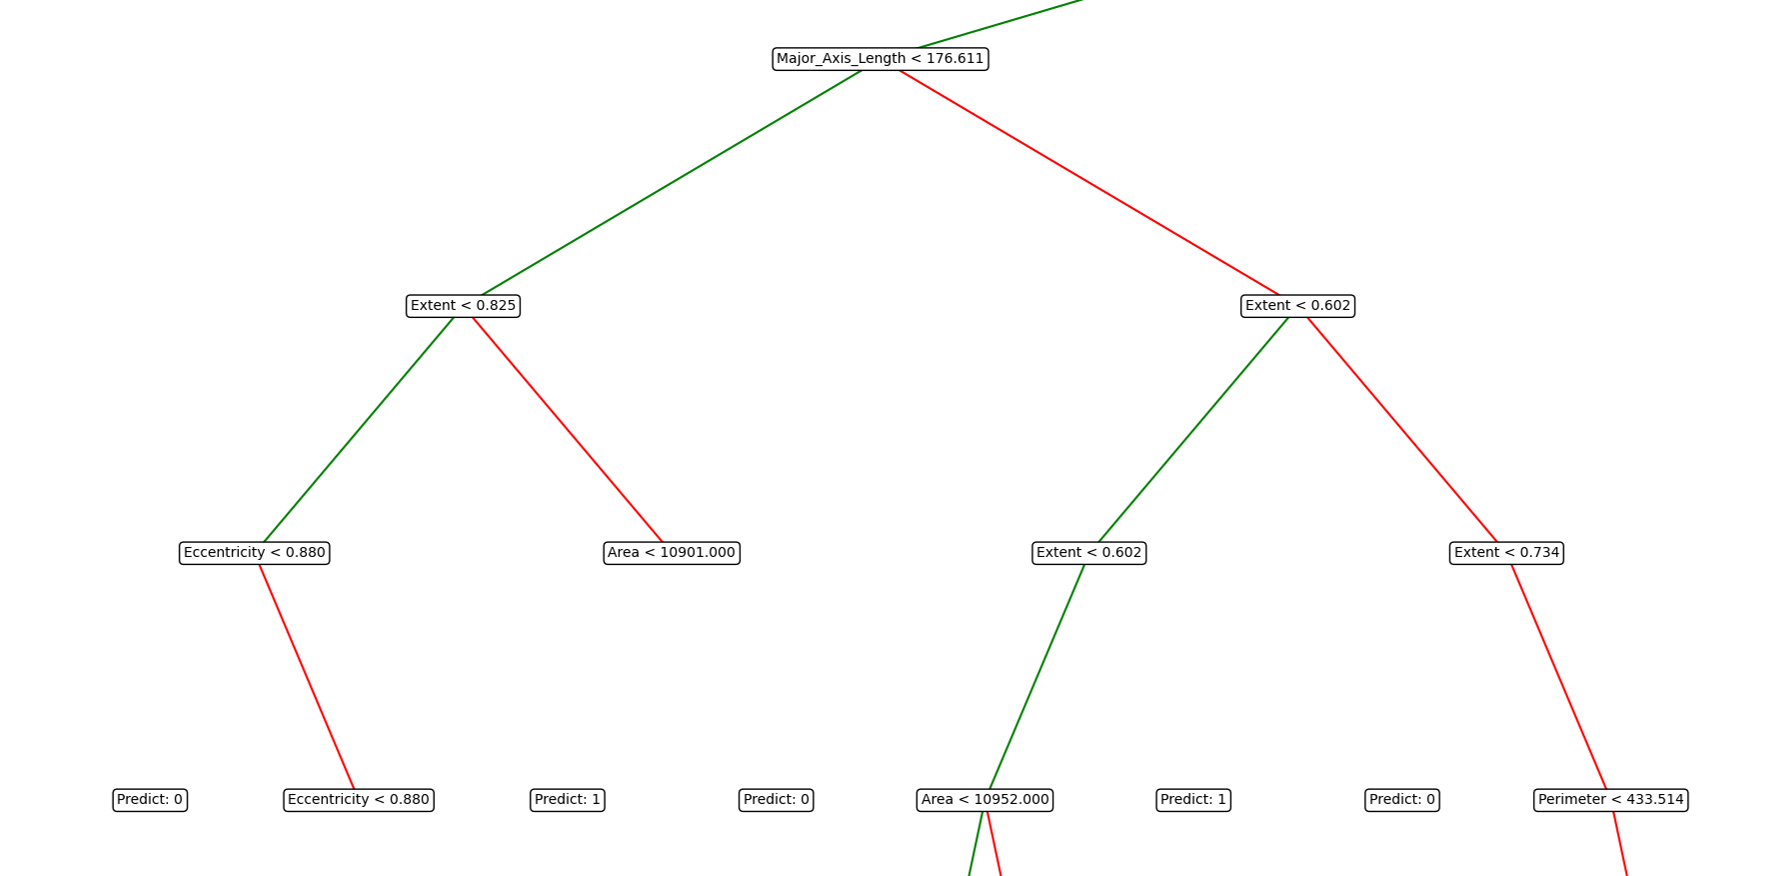

###########################################

Confusion Matrix of tree 1 on TRAIN SET:


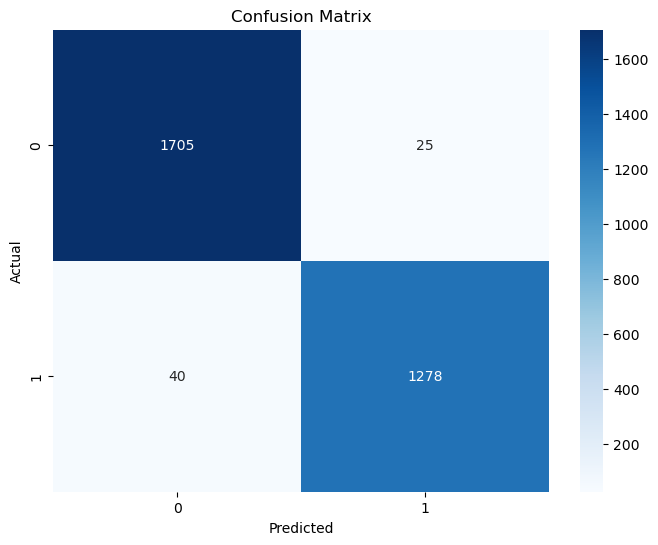

Accuracy of tree 1 on TRAIN SET : 97.87%
Precision of tree 1 on TRAIN SET : 98.08%
Recall of tree 1 on TRAIN SET : 96.97%
F1 Scoreof tree 1 on TRAIN SET : 97.52%
###########################################

Confusion Matrix of tree 2 on TRAIN SET:


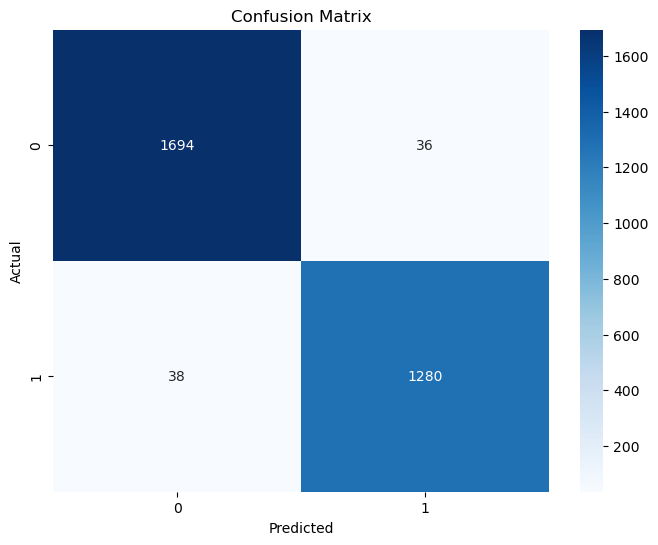

Accuracy of tree 2 on TRAIN SET : 97.57%
Precision of tree 2 on TRAIN SET : 97.26%
Recall of tree 2 on TRAIN SET : 97.12%
F1 Scoreof tree 2 on TRAIN SET : 97.19%
###########################################

Confusion Matrix of tree 3 on TRAIN SET:


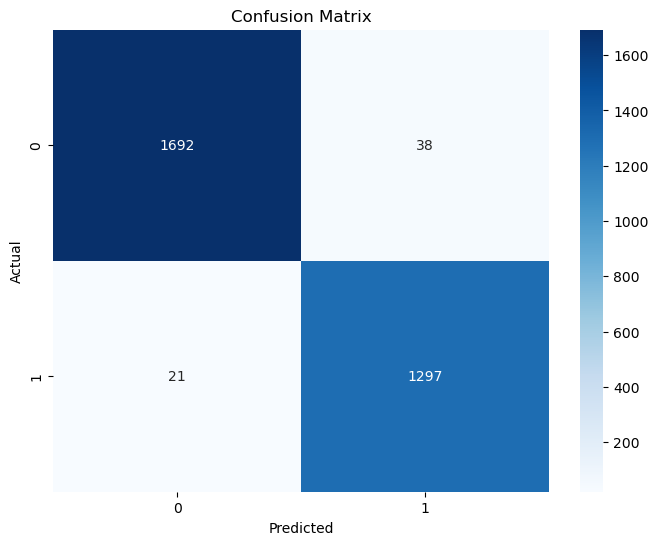

Accuracy of tree 3 on TRAIN SET : 98.06%
Precision of tree 3 on TRAIN SET : 97.15%
Recall of tree 3 on TRAIN SET : 98.41%
F1 Scoreof tree 3 on TRAIN SET : 97.78%
###########################################

Confusion Matrix of tree 4 on TRAIN SET:


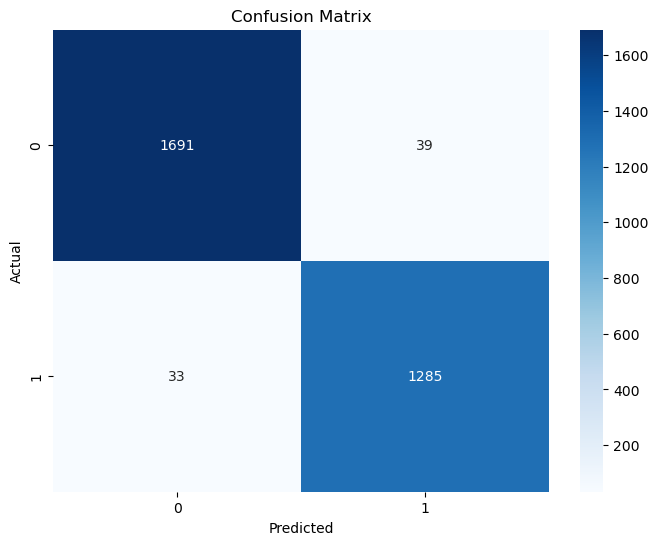

Accuracy of tree 4 on TRAIN SET : 97.64%
Precision of tree 4 on TRAIN SET : 97.05%
Recall of tree 4 on TRAIN SET : 97.50%
F1 Scoreof tree 4 on TRAIN SET : 97.27%
###########################################

Confusion Matrix of tree 5 on TRAIN SET:


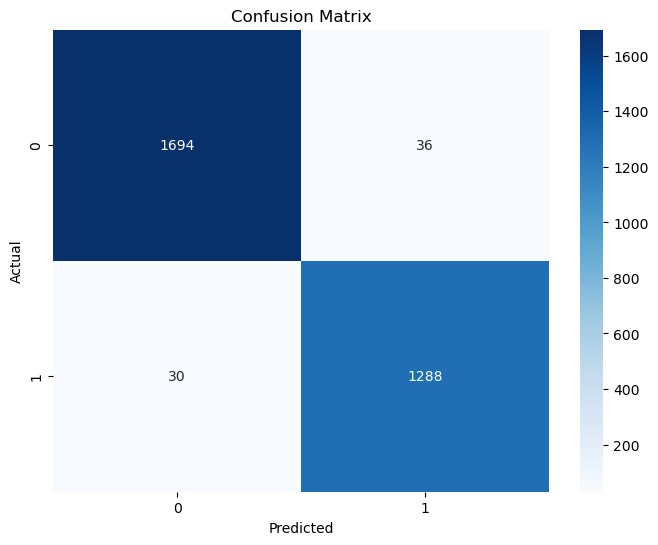

Accuracy of tree 5 on TRAIN SET : 97.83%
Precision of tree 5 on TRAIN SET : 97.28%
Recall of tree 5 on TRAIN SET : 97.72%
F1 Scoreof tree 5 on TRAIN SET : 97.50%


In [17]:
# LETS ALSO SEE HOW THESE TREES WORK ON WHOLE TRAIN DATASET

# lets also store metrics for each tree
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

i = 0
for tree in trees:
    
    # store real values for error calculation
    train_actual_classes = dataset['Class'].values
    
    # make predictions and store them in an array
    train_predicts = []
    for index, row in dataset.iterrows():
        train_prediction = make_prediction(tree, row)
        train_predicts.append(train_prediction)
    train_predictions = np.array(train_predicts)
    
    # accuracy calculation
    train_accuracy = np.mean(train_predictions == train_actual_classes)
    train_accuracies.append(train_accuracy)
    
    # confusion matrix and visualisation with heatmap
    train_confusion_matrix = pd.crosstab(train_actual_classes, train_predictions, rownames=['Actual'], colnames=['Predicted'])
    print("###########################################")
    print(f'\nConfusion Matrix of tree {i+1} on TRAIN SET:')
    plt.figure(figsize=(8, 6))
    sns.heatmap(train_confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()
    
    # calculate other metrices and print them
    train_precision = np.sum((train_predictions == 1) & (train_actual_classes == 1)) / np.sum(train_predictions == 1)
    train_recall = np.sum((train_predictions == 1) & (train_actual_classes == 1)) / np.sum(train_actual_classes == 1)
    train_f1_score = 2 * (train_precision * train_recall) / (train_precision + train_recall)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1_score)
    print(f'Accuracy of tree {i+1} on TRAIN SET : {train_accuracy:.2%}')
    print(f'Precision of tree {i+1} on TRAIN SET : {train_precision:.2%}')
    print(f'Recall of tree {i+1} on TRAIN SET : {train_recall:.2%}')
    print(f'F1 Scoreof tree {i+1} on TRAIN SET : {train_f1_score:.2%}')
    i += 1

Mean Accuracy: 97.80% ± 0.18%
Mean Precision: 97.37% ± 0.37%
Mean Recall: 97.54% ± 0.51%
Mean F1 Score: 97.45% ± 0.21%


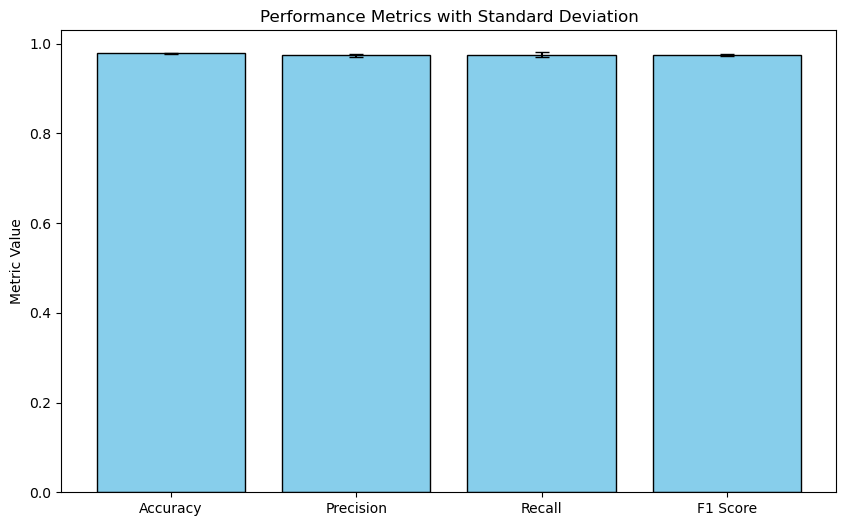

In [18]:
#Let's also see the average results for train dataset
mean_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)

mean_train_precision = np.mean(train_precisions)
std_train_precision = np.std(train_precisions)

mean_train_recall = np.mean(train_recalls)
std_train_recall = np.std(train_recalls)

mean_train_f1_score = np.mean(train_f1_scores)
std_train_f1_score = np.std(train_f1_scores)

# Print the results
print(f'Mean Accuracy: {mean_train_accuracy:.2%} ± {std_train_accuracy:.2%}')
print(f'Mean Precision: {mean_train_precision:.2%} ± {std_train_precision:.2%}')
print(f'Mean Recall: {mean_train_recall:.2%} ± {std_train_recall:.2%}')
print(f'Mean F1 Score: {mean_train_f1_score:.2%} ± {std_train_f1_score:.2%}')

# Metrics and their corresponding means and standard deviations
train_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
train_means = [mean_train_accuracy, mean_train_precision, mean_train_recall, mean_train_f1_score]
train_stds = [std_train_accuracy, std_train_precision, std_train_recall, std_train_f1_score]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot of means with error bars
ax.bar(train_metrics, train_means, yerr=train_stds, capsize=5, color='skyblue', edgecolor='black')

# Set labels and title
ax.set_ylabel('Metric Value')
ax.set_title('Performance Metrics with Standard Deviation')

# Show the plot
plt.show()

As we expect performance metrics on the train dataset is very high since our model knows them. Still not 100% because non of the trees seen the whole train data.